In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn.ensemble import RandomForestClassifier # 잘쓰면 트리모델만큼 좋은게 없다.

from sklearn.model_selection import GridSearchCV # 여러 파라미터를 바꿔가면서 적용시켜 최상의 모델은 구한다
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn import metrics
from sklearn.datasets import load_breast_cancer


import graphviz
from sklearn.tree import export_graphviz
import time

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

# 시스템 폰트패밀리에 따라 변경
plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

In [2]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(data = np.c_[cancer["data"], cancer["target"]],
             columns = list(cancer["feature_names"]) + ["label"]).astype({"label":"category"})

X = cancer_df[cancer_df.columns[:-1]]
y = cancer_df[cancer_df.columns[-1]]

x_train,x_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y)

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
x_test:  (114, 30)
y_train:  (455,)
y_test:  (114,)


In [3]:
model_tree = DecisionTreeClassifier(random_state=42)

model_tree.fit(x_train,y_train)
pred_tree = model_tree.predict(x_test)

metrics.accuracy_score(pred_tree, y_test)

0.9122807017543859

### feature importance

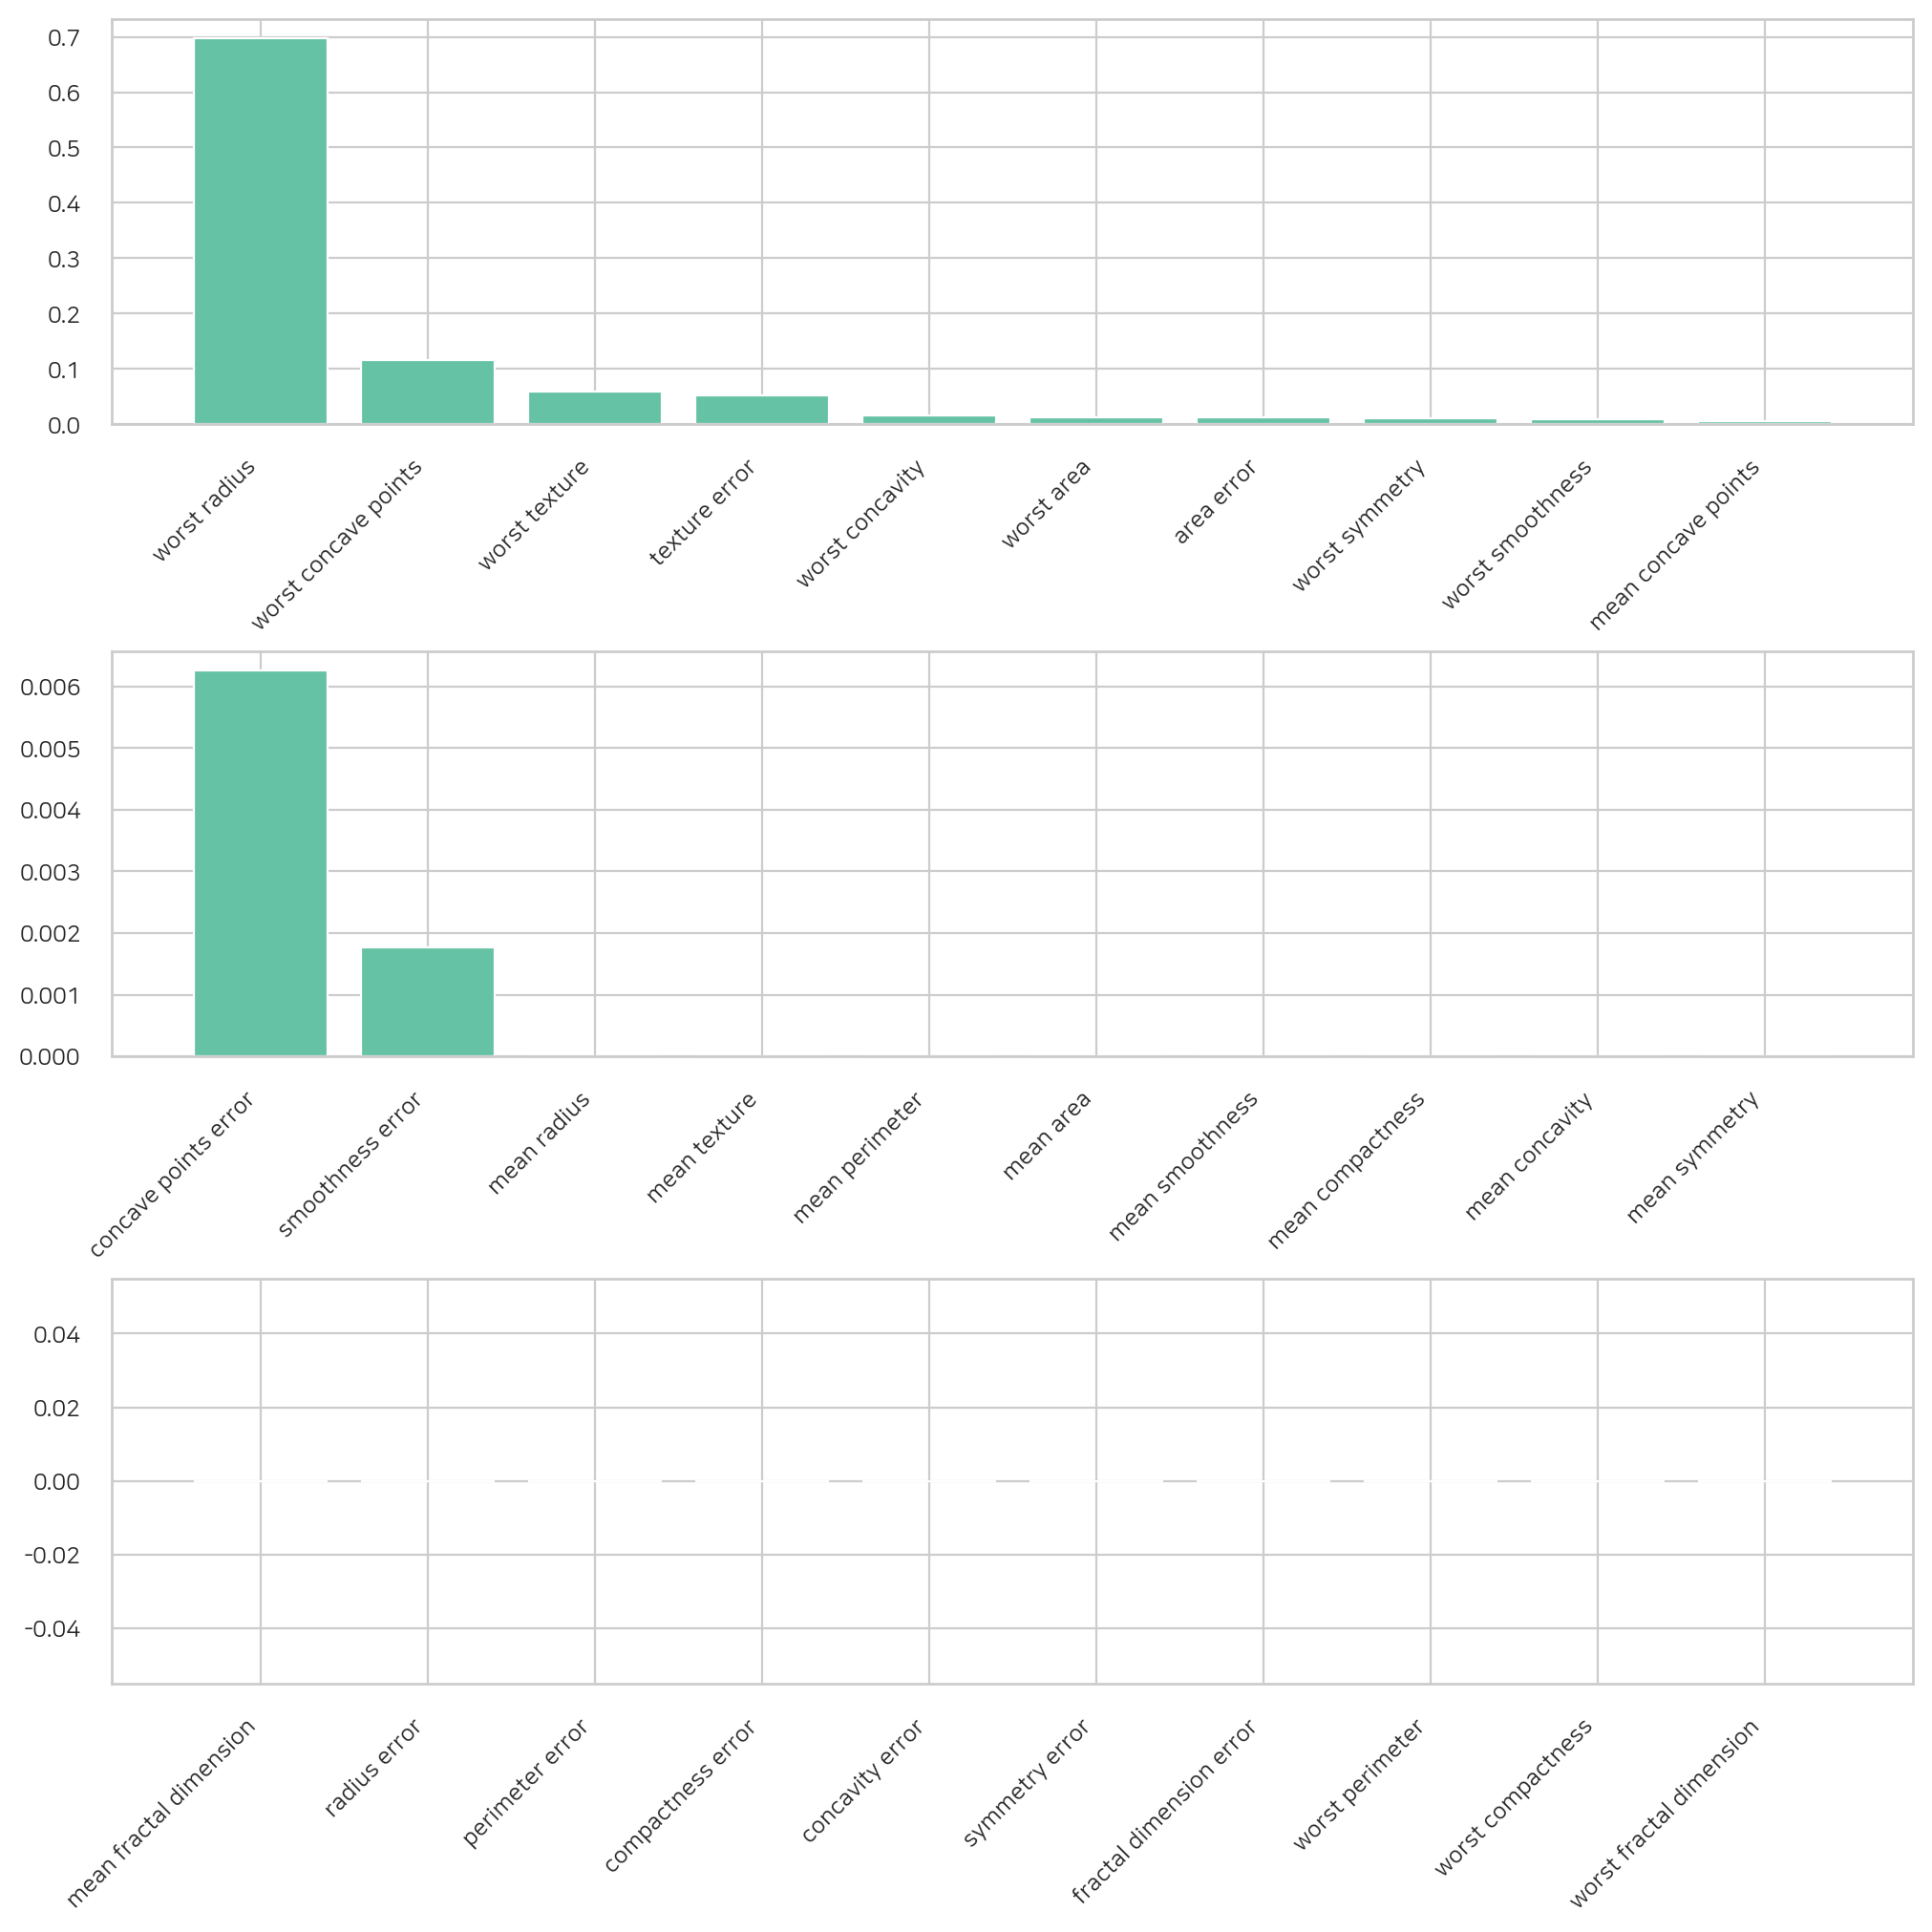

In [4]:
feature_importance = {name: importance for name, importance in zip(X.columns, model_tree.feature_importances_)}
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), 
                                                     key=lambda item: item[1], 
                                                     reverse = True)}

fig, ax = plt.subplots(3,1,figsize = (10,10))

features_ = []
for i in range(10,31,10):
    idx_plot = int(i / 10) - 1

    # 디시전 트리에서의 가장 중요해 보이는 피쳐들순으로 10개씩 피쳐 분류
    fatures =list(feature_importance_sorted.keys())[(i-10):i]
    values = list(feature_importance_sorted.values())[(i-10):i]
    features_.append(fatures)
    ax[idx_plot].bar(fatures, values)
    plt.setp(ax[idx_plot].get_xticklabels(), ha = "right", rotation = 45);

### 랜덤 포레스트 및 디시전 트리를 이용해서 정확도 구해보기

In [5]:
# 피쳐별로 나누어 훈련시키기

def test_train_by_feature(features_):
    X = cancer_df[features_]
    y = cancer_df[cancer_df.columns[-1]]

    x_train,x_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y)
    
    # print("x_train: ", x_train.shape)
    # print("x_test: ", x_test.shape)
    # print("y_train: ", y_train.shape)
    # print("y_test: ", y_test.shape)

    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = test_train_by_feature(features_[1])

In [6]:
def ran_search(x_train,x_test,y_train,y_test,params,iters,model = DecisionTreeClassifier(random_state=209)):
    model_base = RandomizedSearchCV(model,
                              params,
                              n_iter= iters,
                              cv = 3,
                              return_train_score=True,
                              n_jobs = -1,
                              random_state=97)
    # print("현재 모델명:" , type(model))
    model_base.fit(x_train, y_train)

    # print("최상 매개변수:", model_base.best_params_)
    # print("최고 정확도:", model_base.best_score_)
    
    best_model = model_base.best_estimator_
    best_pred = best_model.predict(x_test)
    # print("최고 정확도", metrics.accuracy_score(best_pred,y_test))


    return model_base, best_model

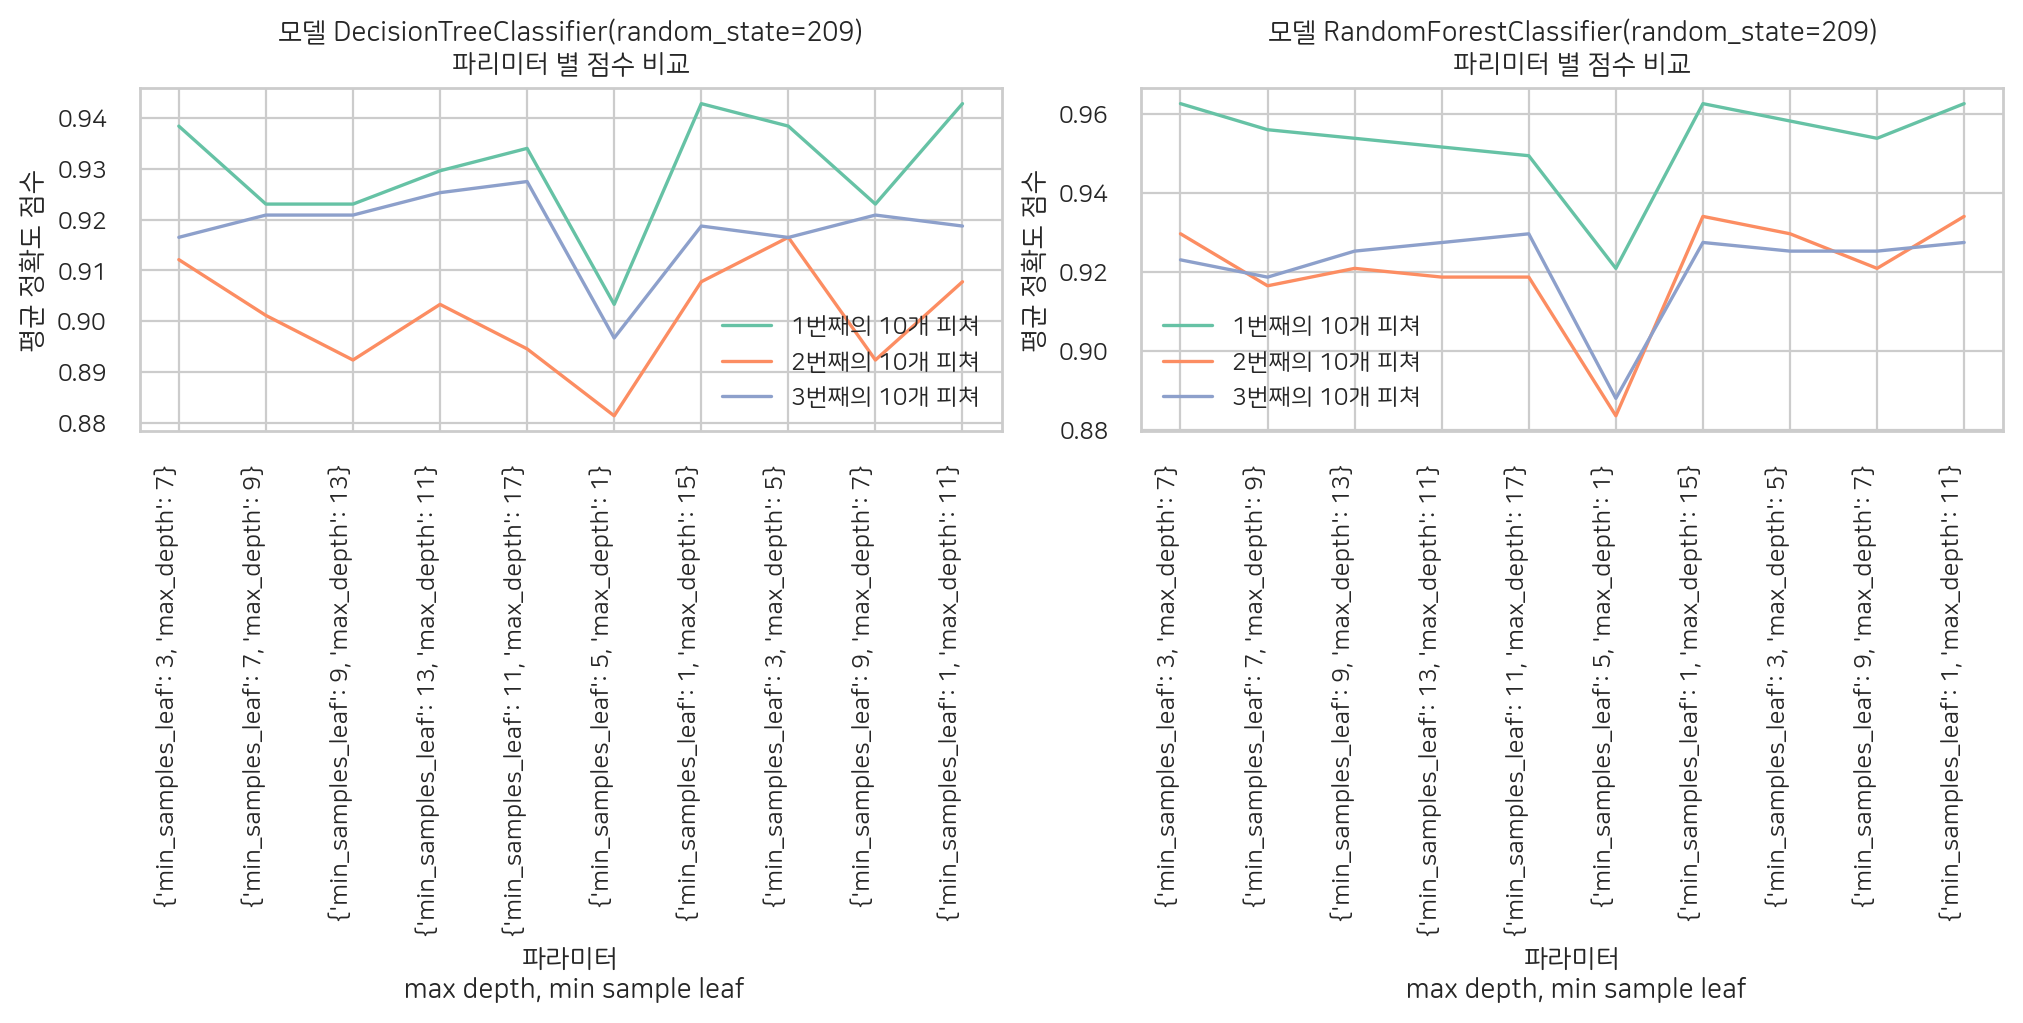

In [7]:
params = {
    "max_depth" : [i for i in range(1,20,2)],
    "min_samples_leaf" : [i for i in range(1,20,2)]
}

fig, ax = plt.subplots(1,2,figsize=(10,5))

# 디시전 트리와 랜덤포레스트의 성능 비교해보기
models = [DecisionTreeClassifier(random_state=209), RandomForestClassifier(random_state=209)]

for fs in features_:
    rank = features_.index(fs) + 1
    for i in range(len(models)):
        x_train,x_test,y_train,y_test = test_train_by_feature(fs)
        model_result, _ = ran_search(x_train,x_test,y_train,y_test,params,10,models[i])
        model_result =  model_result.cv_results_
        sns.lineplot(x = [str(j) for j in model_result["params"]],
                     y = model_result["mean_test_score"],
                     label = f"{rank}번째의 10개 피쳐",
                     ax=ax[i])
        ax[i].set(xlabel="파라미터\n max depth, min sample leaf",
               ylabel="평균 정확도 점수",
               title=f"모델 {models[i]}\n파리미터 별 점수 비교")
        plt.setp(ax[i].get_xticklabels(),ha = "right", rotation = 90);

#### 랜덤 포레스트에서 가장 중요한 피쳐부터 하나씩 추가해서 비교해 보기

/home/tommy/miniconda3/envs/p311/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


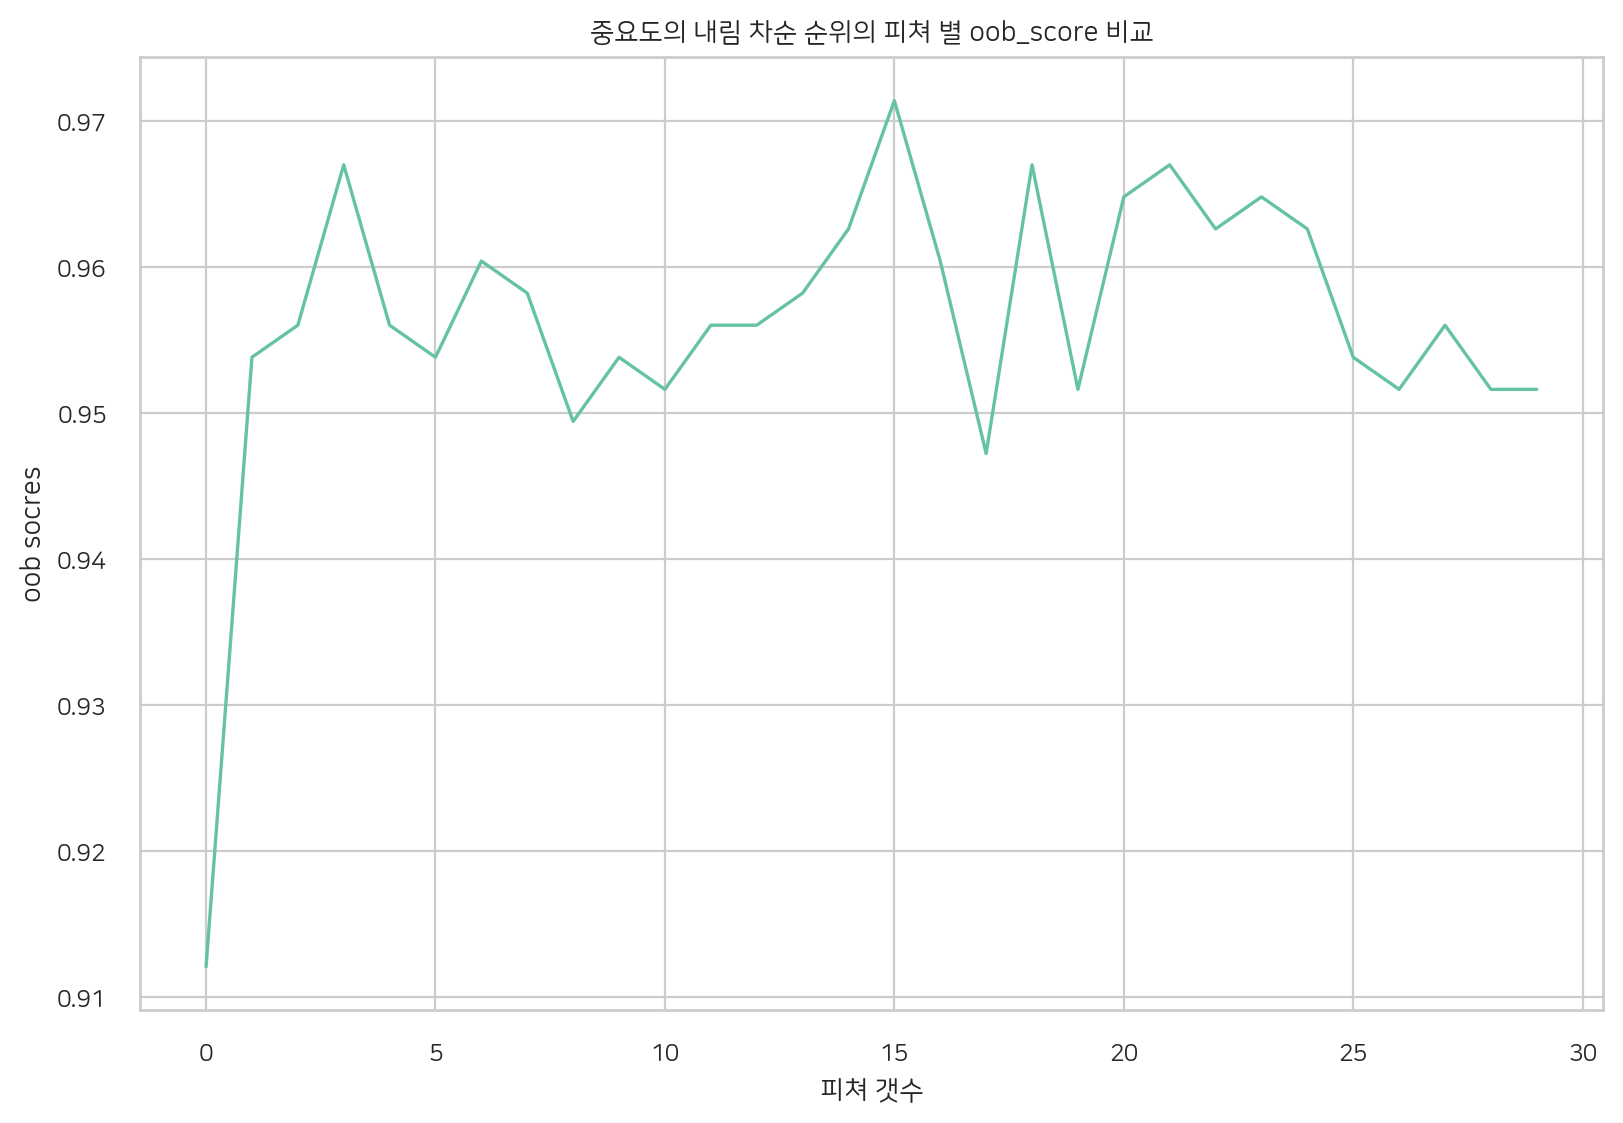

In [8]:
x_train,x_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y)

feature_importance = {name: importance for name, importance in zip(X.columns, model_tree.feature_importances_)}
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), 
                                                     key=lambda item: item[1], 
                                                     reverse = True)}
# 베스트 파라미터
best_params = {
    "max_depth" : 15,
    "min_samples_leaf" : 1
}

dict_by_feature_n = {}
for i in range(len(feature_importance_sorted)):
    
    feature = list(feature_importance_sorted.keys())[:i+1]
    x_train,x_test,y_train,y_test = test_train_by_feature(feature)

    model_result, best_model = ran_search(x_train,
                              x_test,
                              y_train,
                              y_test,params,
                              10,
                              RandomForestClassifier(
                                  n_estimators=20,
                                  oob_score=True,
                                  random_state=209))
    dict_by_feature_n[i] = best_model.oob_score_

fig, ax = plt.subplots()
sns.lineplot(x = dict_by_feature_n.keys(),
             y = dict_by_feature_n.values(), ax=ax)
ax.set(xlabel="피쳐 갯수",
       ylabel="oob socres",
       title="중요도의 내림 차순 순위의 피쳐 별 oob_score 비교");

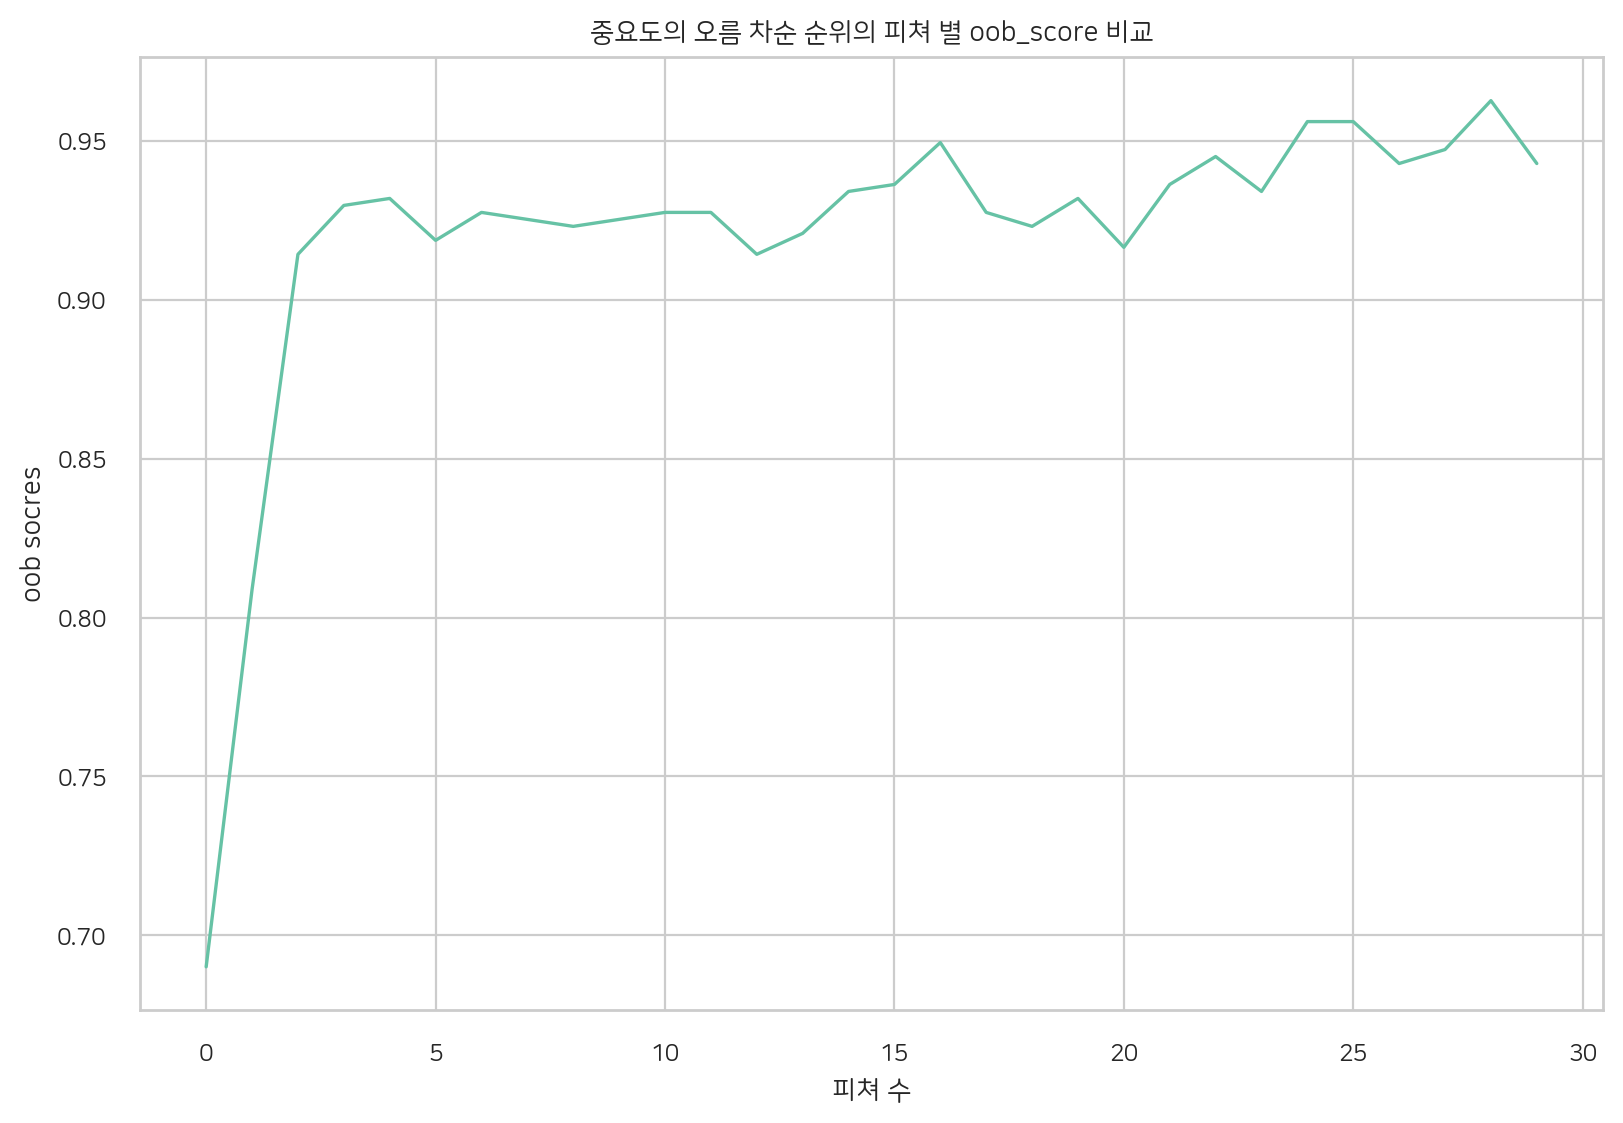

In [9]:
dict_by_feature_n = {}
for i in range(len(feature_importance_sorted)):
    
    feature = list(feature_importance_sorted.keys())[-1:-i-2:-1]
    x_train,x_test,y_train,y_test = test_train_by_feature(feature)

    model_result, best_model = ran_search(x_train,
                              x_test,
                              y_train,
                              y_test,params,
                              10,
                              RandomForestClassifier(
                                  n_estimators=20,
                                  oob_score=True,
                                  random_state=209))
    dict_by_feature_n[i] = best_model.oob_score_

fig, ax = plt.subplots()
sns.lineplot(x = dict_by_feature_n.keys(),
             y = dict_by_feature_n.values(), ax=ax)
ax.set(xlabel="피쳐 수",
       ylabel="oob socres",
       title="중요도의 오름 차순 순위의 피쳐 별 oob_score 비교");